In [1]:
import PIL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as sklm

import torch
import pytorch_lightning as pl

import dataset
import neural_network
import config as cfg

torch.__version__

'1.12.1.post201'

In [2]:
import sys
print(sys.version)

3.10.6 | packaged by conda-forge | (main, Aug 22 2022, 20:35:26) [GCC 10.4.0]


## Parameters

In [3]:
print(f"Num GPUs Available: {torch.cuda.device_count()}")

Num GPUs Available: 1


## Classes

In [4]:
CLASSES = dataset.metadata.get_classes(cfg.paths.LABELS_CSV["train"])  
CLASSES, CLASSES.size

(array(['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'], dtype='<U5'), 7)

## Preprocessing Dataset

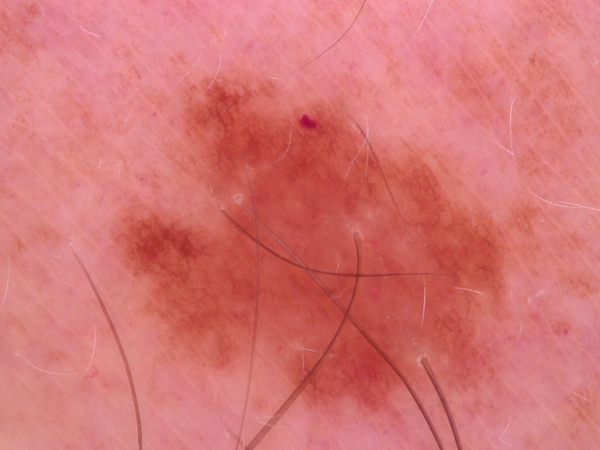

In [5]:
train_filenames = cfg.paths.IMG_DIR["train"].glob("*.jpg")

filename = next(train_filenames)
PIL.Image.open(filename)

In [6]:
IMG_CHANNELS, IMG_HEIGHT, IMG_WIDTH = dataset.metadata.get_image_dimensions(cfg.paths.IMG_DIR["train"])
IMG_CHANNELS, IMG_HEIGHT, IMG_WIDTH

(3, 450, 600)

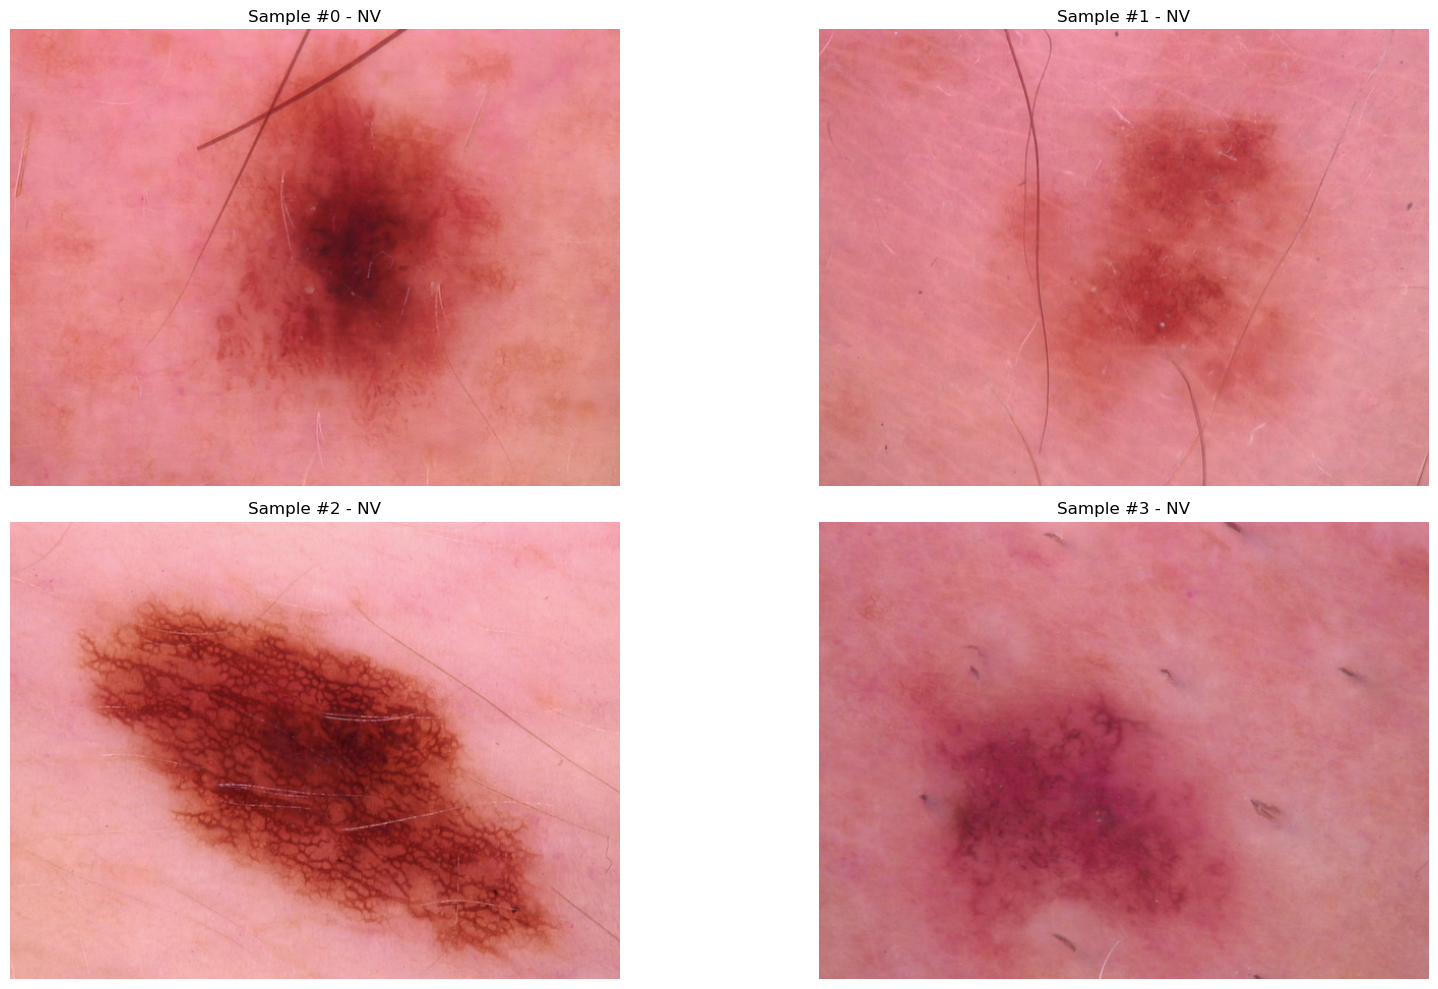

In [7]:
train = dataset.SkinCancerDataset(cfg.paths.LABELS_CSV["train"], cfg.paths.IMG_DIR["train"])
dataset.plot_some_samples(2, 2, train, CLASSES)

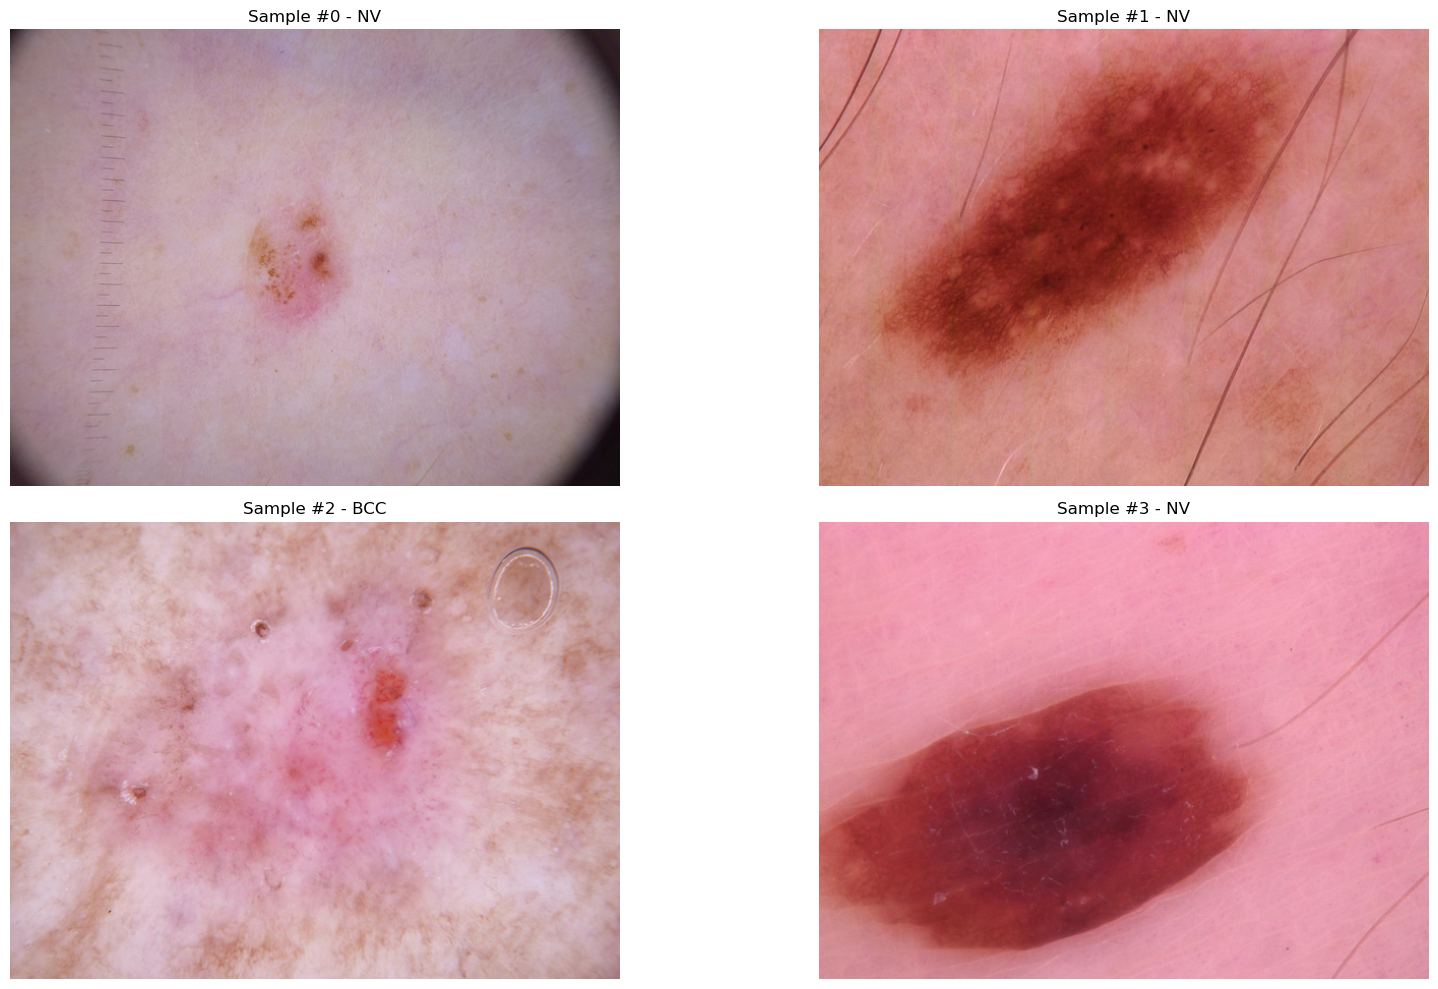

In [8]:
test = dataset.SkinCancerDataset(cfg.paths.LABELS_CSV["test"], cfg.paths.IMG_DIR["test"])
dataset.plot_some_samples(2, 2, test, CLASSES)

## Modeling the CNN

In [9]:
SEED = 1
pl.seed_everything(SEED, workers=True)

Global seed set to 1


1

In [10]:
# I think it should be rescaled here
# model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
data_module = dataset.SkinCancerDataModule(
    cfg.paths.LABELS_CSV,
    cfg.paths.IMG_DIR,
    cfg.hparams.BATCH_SIZE,
    cfg.hparams.DATALOADER_NUM_WORKERS,
    transform=None
)

In [11]:
model = neural_network.ConvNetwork(CLASSES.size, cfg.hparams.DROPOUT_RATE)
print(model)

ConvNetwork(
  (first_conv): Sequential(
    (0): LazyConv2d(0, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): LazyConv2d(0, 16, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): Dropout(p=0.25, inplace=False)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (second_conv): Sequential(
    (0): LazyConv2d(0, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): LazyConv2d(0, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): Dropout(p=0.25, inplace=False)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (third_conv): Sequential(
    (0): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): Dropout(p=0.25, inplace=False)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fully_connected): Sequential(
    (0): Flatten(

/home/estefano/anaconda3/envs/skin_cancer/lib/python3.10/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [12]:
model_module = neural_network.NetworkModule(
    model,
    IMG_CHANNELS,
    IMG_HEIGHT,
    IMG_WIDTH,
    CLASSES.size,
    cfg.hparams.LEARNING_RATE
)

In [13]:
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.callbacks.progress import TQDMProgressBar

progress_bar = TQDMProgressBar()
validation = EarlyStopping("val_loss")
checkpoint = ModelCheckpoint(save_top_k=3, monitor="val_loss")

trainer_callbacks = [progress_bar, validation, checkpoint]

In [14]:
from pytorch_lightning.loggers import CSVLogger

logger = CSVLogger(cfg.paths.LOG_DIR)

In [15]:
trainer = pl.Trainer(
    min_epochs=5,
    max_epochs=20,
    accelerator="auto",
    devices="auto",
    logger=logger,
    callbacks=trainer_callbacks,
    deterministic=True,
    # mostly parameters below can be removed
    # when we want to fully train our network
    limit_train_batches=0.10,
    limit_val_batches=0.1,
    log_every_n_steps=25,
)

trainer.fit(model=model_module, datamodule=data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /home/estefano/Music/skin-cancer/logs/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/estefano/anaconda3/envs/skin_cancer/lib/python3.10/site-packages/pytorch_lightning/utilities/model_summary/model_summary.py:410: UserWarning: A layer with UninitializedParameter was found. Thus, the total number of parameters detected may be inaccurate.
  warning_cache.warn(

  | Name  | Type        | Params
--------------------------------------
0 | model | ConvNetwork | 0     
--------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

## Metrics

In [16]:
checkpoint.best_k_models

{'/home/estefano/Music/skin-cancer/logs/lightning_logs/version_0/checkpoints/epoch=0-step=53.ckpt': tensor(-0.2108, device='cuda:0'),
 '/home/estefano/Music/skin-cancer/logs/lightning_logs/version_0/checkpoints/epoch=1-step=106.ckpt': tensor(-0.4719, device='cuda:0'),
 '/home/estefano/Music/skin-cancer/logs/lightning_logs/version_0/checkpoints/epoch=3-step=212.ckpt': tensor(-0.2446, device='cuda:0')}

In [17]:
# each time you train a neural network
# it logs the information to a new version folder
version = 0
VERSION_DIR = cfg.paths.LOG_DIR / f"lightning_logs/version_{version}"

In [18]:
METRICS_PATH = VERSION_DIR / "metrics.csv"

metrics = pd.read_csv(METRICS_PATH).set_index(["epoch", "step"])

train = metrics[["train_loss_epoch", "train_acc_epoch"]].dropna()
validation = metrics[["val_loss", "val_acc"]].dropna()

validation

val_loss   val_acc
epoch step                    
0     52   -0.210768  0.423611
1     105  -0.471869  0.548611
2     158  -0.142999  0.152778
3     211  -0.244551  0.486111
4     264  -0.170671  0.125000

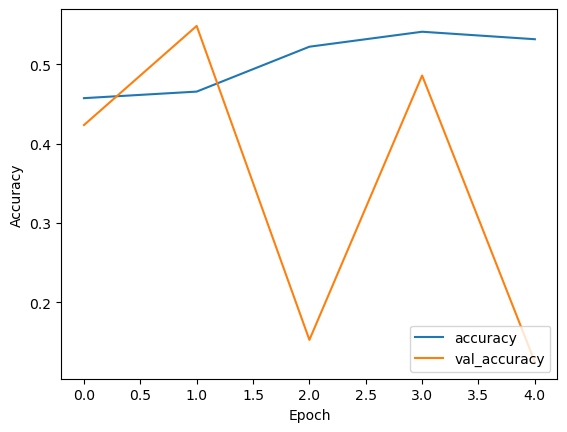

In [19]:
epochs = train.index.get_level_values("epoch")

plt.plot(epochs, train["train_acc_epoch"], label="accuracy")
plt.plot(epochs, validation["val_acc"], label = "val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

## Confusion Matrix

In [20]:
model_module.clear_test_predictions_variables()
trainer.test(model_module, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.12435232847929001
        test_loss           1.9439265727996826
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.9439265727996826, 'test_acc': 0.12435232847929001}]

In [21]:
true_labels_pos = torch.concat(model_module.test_expected).cpu()

predicted_probabilities = torch.concat(model_module.test_probabilities)
predicted_labels_pos = predicted_probabilities.argmax(dim=1).cpu()

true_labels = CLASSES[true_labels_pos]
predicted_labels = CLASSES[predicted_labels_pos]

In [22]:
confusion_matrix = pd.crosstab(true_labels, predicted_labels, rownames=["Actual"], colnames=["Predicted"])
confusion_matrix

Predicted  BKL  MEL
Actual             
AKIEC        3    5
BCC          4   11
BKL          5   17
DF           1    0
MEL          2   19
NV          74   49
VASC         1    2

In [23]:
report = sklm.classification_report(true_labels_pos, predicted_labels_pos, target_names=CLASSES)
print(report)

              precision    recall  f1-score   support

         MEL       0.18      0.90      0.31        21
          NV       0.00      0.00      0.00       123
         BCC       0.00      0.00      0.00        15
       AKIEC       0.00      0.00      0.00         8
         BKL       0.06      0.23      0.09        22
          DF       0.00      0.00      0.00         1
        VASC       0.00      0.00      0.00         3

    accuracy                           0.12       193
   macro avg       0.03      0.16      0.06       193
weighted avg       0.03      0.12      0.04       193



/home/estefano/anaconda3/envs/skin_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/estefano/anaconda3/envs/skin_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/estefano/anaconda3/envs/skin_cancer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif